在Pytorch中，神经网络通过torch.nn包来构建。
一个nn.Module包括层和一个forward方法，它将返回输出
<br>
一个典型的神经网络训练过程应该包括以下几点：

    1. 定义一个可训练参数的神经网络
    2. 迭代整个输入
    3. 通过神经网络处理输入
    4. 计算损失
    5. 反向传播梯度到神经网络的参数
    6. 更新网络的参数

In [1]:
# 定义一个神经网络
import torch
import torch.nn as nn
import torch.nn.functional as func


class MyModel(nn.Module):
    """
    开始定义自己模型的层和方法
    """
    def __init__(self):
        super(MyModel, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16*5*5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        
    
    def forward(self, x):
        x = func.max_pool2d(func.relu(self.conv1(x)), (2, 2))
        x = func.max_pool2d(func.relu(self.conv2(x)), (2, 2))
        x = x.view(-1, self.num_flat_features(x))
        x = func.relu(self.fc1(x))
        x = func.relu(self.fc2(x))
        return self.fc3(x)
    
    
    def num_flat_features(self, x):
        size = x.size()[1:]
        num_features = 1
        for s in size:
            num_features *= s
        return num_features
model = MyModel()
print(model)

MyModel(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


In [2]:
# 一个模型可训练的参数可以通过调用net.parameters()返回
params = list(model.parameters())
print(len(params))
for param in params:
    print(param.size())

10
torch.Size([6, 1, 5, 5])
torch.Size([6])
torch.Size([16, 6, 5, 5])
torch.Size([16])
torch.Size([120, 400])
torch.Size([120])
torch.Size([84, 120])
torch.Size([84])
torch.Size([10, 84])
torch.Size([10])


In [3]:
# 让我们常识随机输入一个32 * 32的输入，注意，上述定义的网络期望的输入就是32 * 32

test_data = torch.randn(1, 1, 32, 32)
out = model(test_data)
print(out)

tensor([[ 0.0717,  0.0864,  0.0768,  0.0818,  0.0466, -0.0705, -0.1025,  0.1148,
          0.0151, -0.0563]], grad_fn=<AddmmBackward>)


In [4]:
# 把所有参数梯度清零，用随机的梯度来反向传播
model.zero_grad()
out.backward(torch.randn(1, 10))

In [5]:
# 演示如何利用反向传播，对模型的参数进行更新
out = model(test_data)
target = torch.randn(1, 10)
criterion = nn.MSELoss()
loss = criterion(out, target)
print(loss)

tensor(0.3878, grad_fn=<MseLossBackward>)


In [6]:
# 同样清空模型参数原有累计的梯度
model.zero_grad()
print(model.conv1.bias.grad)
loss.backward()
print(model.conv1.bias.grad)

tensor([0., 0., 0., 0., 0., 0.])
tensor([-2.6912e-03,  5.1811e-03, -5.9812e-03, -7.1785e-05,  3.1091e-04,
        -1.2411e-02])


In [7]:
# 在实际优化的时候，通常是使用工具而不是手动更新
import torch.optim as optim

optimizer = optim.SGD(model.parameters(), lr=0.01)
out = model(test_data)
loss = criterion(out, target)
loss.backward()
optimizer.step()

In [8]:
import torchvision
# 注意下列语句会引入pillow module中的PILLOW_VISION，这个包在7.0中已经被移除了，故pip install pillow==6.1
import torchvision.transforms as transforms

#### torchvision是Pytorch内置数据集，也包含了常用的数据处理工具
- torchvision.datasets 包含常用的数据集，例如minist,COCO等等
- torchvision.models包含常用的著名网络结构，AlexNet, VGG, ResNet等等
- torchvision.transforms是Pytorch中对图像处理的包

现列出用于图像处理的transforms中的主要函数
<br>transforms.ToTensor()方法一个返回一个可以将shape为(H, W, C)的张量变成(C, H, W)形状的方法
<br>transforms.ToPILImage()方法返回一个可以将shape为(C, H, W)的张量变成(H, W, C)形状的方法
<br>transforms.Scale(size)方法返回一个可以改变输入图像到指定大小的方法。其中size为图像的最短边长(长或者宽)，该方法是按比例缩放。
<br>transforms.Normalize(mean, std): 给定均值和标准差，返回一个可以正则化图形的函数。
<br>transforms.Pad(padding, fill=0),padding代表要填充的像素， file代表要填充的颜色，fill默认值为0 

In [9]:
# 使用Scale示例
from PIL import Image
scaler = transforms.Scale(500)
image = Image.open("./example.jpeg")
print(image.size)
print(scaler(image).size)

(1182, 665)
(888, 500)


/home/fang/anaconda3/envs/chenguang/lib/python3.7/site-packages/torchvision/transforms/transforms.py:219: UserWarning: The use of the transforms.Scale transform is deprecated, please use transforms.Resize instead.
  warnings.warn("The use of the transforms.Scale transform is deprecated, " +


In [10]:
# 使用normalize示例
import numpy as np
image_array = np.asarray(image)
print(image_array.shape)
image_tensor = transforms.ToTensor()(image_array)
image_norm = transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))(image_tensor)
print(image_tensor[:, 0, 0])
print(image_norm[:, 0, 0])

(665, 1182, 3)
tensor([0.1098, 0.1373, 0.2000])
tensor([-0.7804, -0.7255, -0.6000])


In [11]:
# 使用Pad示例
image_resize = transforms.Resize((6, 6))(image)
print(np.asarray(image_resize)[0])
print(np.asarray(image_resize).shape)
image_pad = transforms.Pad(padding=1, fill=0)(image_resize)
print(np.asarray(image_pad)[1])
print(np.asarray(image_pad).shape)

[[28 41 64]
 [28 41 64]
 [28 41 64]
 [28 41 64]
 [28 41 64]
 [28 41 64]]
(6, 6, 3)
[[ 0  0  0]
 [28 41 64]
 [28 41 64]
 [28 41 64]
 [28 41 64]
 [28 41 64]
 [28 41 64]
 [ 0  0  0]]
(8, 8, 3)


In [12]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

trainset = torchvision.datasets.CIFAR10(root='./data', train = True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train = False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4, shuffle=False, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


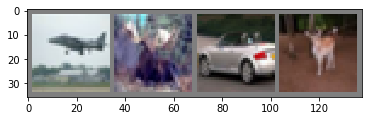

tensor([0, 4, 1, 4])


In [13]:
# 展示一些数据集中的训练图片
import matplotlib.pyplot as plt
import numpy as np

#function to show an image
def image_show(image: torch.Tensor):
    image = image / 2  + 0.5 # unnormalize
    np_image = image.numpy()
    plt.imshow(np.transpose(np_image, (1, 2, 0)))
    plt.show()
    
data_iter = iter(trainloader)
images, labels = data_iter.next()
image_show(torchvision.utils.make_grid(images))
print(labels)

In [14]:
# 定义一个新的可以用来分类上述数据的CNN model
class Classifier(nn.Module):
    def __init__(self):
        super(Classifier, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16*5*5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        
    def forward(self, x):
        x = self.pool(func.relu(self.conv1(x)))
        x = self.pool(func.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = func.relu(self.fc1(x))
        x = func.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
model = Classifier()
print(model)

Classifier(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


In [22]:
# 定义一个损失函数和优化器，再在数据迭代器上训练模型即可
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
for epoch in range(3):
    runniing_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        runniing_loss += loss.item()
        if i % 2000 == 1999:
            print('[%d, %5d] loss: %.3f' %(epoch + 1, i + 1, runniing_loss / 2000))
            runniing_loss = 0.0

[1,  2000] loss: 1.087
[1,  4000] loss: 1.086
[1,  6000] loss: 1.108
[1,  8000] loss: 1.084
[1, 10000] loss: 1.099
[1, 12000] loss: 1.112
[2,  2000] loss: 1.004
[2,  4000] loss: 1.020
[2,  6000] loss: 1.031
[2,  8000] loss: 1.017
[2, 10000] loss: 1.042
[2, 12000] loss: 1.038
[3,  2000] loss: 0.936
[3,  4000] loss: 0.957
[3,  6000] loss: 0.980
[3,  8000] loss: 0.951
[3, 10000] loss: 0.969
[3, 12000] loss: 0.985


In [15]:
predicted = torch.max(model(images), 1)
print(predicted)
print(labels)

torch.return_types.max(
values=tensor([0.1034, 0.1082, 0.1159, 0.1119], grad_fn=<MaxBackward0>),
indices=tensor([8, 8, 8, 8]))
tensor([0, 4, 1, 4])


In [26]:
# 输出经过训练的模型在测试集上的准确率。
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
print("Accuracy of the net work on the 10000 test images: %d %%" % (100*correct/total))

Accuracy of the net work on the 10000 test images: 62 %


In [16]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [29]:
# 尝试使用GPU训练模型
model.to(device)
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
for epoch in range(3):
    runniing_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        optimizer.zero_grad()
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        runniing_loss += loss.item()
        if i % 2000 == 1999:
            print('[%d, %5d] loss: %.3f' %(epoch + 1, i + 1, runniing_loss / 2000))
            runniing_loss = 0.0

[1,  2000] loss: 0.879
[1,  4000] loss: 0.929
[1,  6000] loss: 0.937
[1,  8000] loss: 0.935
[1, 10000] loss: 0.937
[1, 12000] loss: 0.922
[2,  2000] loss: 0.843
[2,  4000] loss: 0.871
[2,  6000] loss: 0.891
[2,  8000] loss: 0.883
[2, 10000] loss: 0.904
[2, 12000] loss: 0.901
[3,  2000] loss: 0.799
[3,  4000] loss: 0.824
[3,  6000] loss: 0.830
[3,  8000] loss: 0.899
[3, 10000] loss: 0.845
[3, 12000] loss: 0.870


# Pytorch中的数据并行

在pytorch中，使用DataParallel可以实现多GPU同时操作数据。

In [17]:
# 先将模型移动到一个GPU中
device = torch.device("cuda:0")
model.to(device)

Classifier(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [18]:
# 然后将训练数据也移动到GPU中。例如，将inputs移动到GPU上
data_iter = iter(trainloader)
inputs, labels = data_iter.next()
inputs = inputs.to(device)

In [20]:
# 设计一个小例子
from torch.utils.data import DataLoader, Dataset

input_size = 5
output_size = 2
batch_size = 30
data_size = 100

# device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# 一个实验性的数据集，需要自己实现getitem()方法
class RandomDataset(Dataset):
    def __init__(self, size, length):
        self.length = length
        self.data = torch.randn(self.length, size)
        
    def __getitem__(self, index):
        return self.data[index]
    
    def __len__(self):
        return self.length
    
rand_loader = DataLoader(dataset=RandomDataset(input_size, data_size), batch_size=batch_size, shuffle=True)

In [21]:
class Model(nn.Module):
    def __init__(self, input_size, output_size):
        super(Model, self).__init__()
        self.fc = nn.Linear(input_size, output_size)
        
    def forward(self, x):
        outputs = self.fc(x)
        print("\tIn Model: input size:", x.size(), "output size: ", outputs.size())
        return outputs

In [22]:
model = Model(input_size, output_size)
model = nn.DataParallel(model)
model.to(device)

DataParallel(
  (module): Model(
    (fc): Linear(in_features=5, out_features=2, bias=True)
  )
)

In [23]:
for data in rand_loader:
    inputs = data.to(device)
    outputs = model(inputs)
    print("Outsize: input size", inputs.size(), "output size", outputs.size())

	In Model: input_size: torch.Size([30, 5]) output size:  torch.Size([30, 2])
Outsize: input size torch.Size([30, 5]) output size torch.Size([30, 2])
	In Model: input_size: torch.Size([30, 5]) output size:  torch.Size([30, 2])
Outsize: input size torch.Size([30, 5]) output size torch.Size([30, 2])
	In Model: input_size: torch.Size([30, 5]) output size:  torch.Size([30, 2])
Outsize: input size torch.Size([30, 5]) output size torch.Size([30, 2])
	In Model: input_size: torch.Size([10, 5]) output size:  torch.Size([10, 2])
Outsize: input size torch.Size([10, 5]) output size torch.Size([10, 2])


上述过程，由于编码本脚本的电脑只有一片GPU，所以在一次迭代的时候输入大小为[30, 5]，如果有多个GPU，那么每一个GPU上的输入为[30/gpu_num, 5]，并行运行，然后再合并所有的结果，所以不管几片GPU，输出的大小永远为[30, 2]